In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
import pathlib
path = './dataset/deu.txt'

In [3]:
def read_file(path):
    path_to_file = pathlib.Path(path)
    text = path_to_file.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t')[:2] for line in lines]
    context = np.array([context for target, context in pairs])
    target = np.array([target for target,context in pairs])
    return context, target

In [4]:
context, target = read_file(path)

In [5]:
print(context[:10])

['Geh.' 'Hallo!' 'Grüß Gott!' 'Lauf!' 'Lauf!' 'Potzdonner!'
 'Donnerwetter!' 'Kopf runter!' 'Feuer!' 'Hilfe!']


In [6]:
print(target[:10])

['Go.' 'Hi.' 'Hi.' 'Run!' 'Run.' 'Wow!' 'Wow!' 'Duck!' 'Fire!' 'Help!']


In [7]:
context[100:110]

array(['Das kommt nicht in Frage!', 'Das gibt’s doch nicht!',
       'Ausgeschlossen!', 'In keinster Weise!', 'Wirklich?', 'Echt?',
       'Im Ernst?', 'Danke!', 'Danke!', 'Versuch’s!'], dtype='<U491')

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = len(context)
is_train = np.random.uniform(size=(len(target),)) < 0.8

train_raw = (tf.data.Dataset
            .from_tensor_slices((context[is_train], target[is_train]))
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE))

val_raw = (tf.data.Dataset
          .from_tensor_slices((context[~is_train], target[~is_train]))
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE))

In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Fast w\xc3\xa4re es komisch gewesen.' b'Tom schlug das Buch zu.'
 b'Das ist schlicht und einfach nicht wahr.'
 b'Wir werden uns wiedersehen.'
 b'Ich w\xc3\xbcnschte, du w\xc3\xa4rest zu Hause geblieben.'], shape=(5,), dtype=string)

tf.Tensor(
[b'It was almost funny.' b'Tom closed the book.'
 b'This is simply not true.' b"We'll meet again."
 b"I wish you would've stayed home."], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant('Das kommt nicht in Frage!')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Das kommt nicht in Frage!'
b'Das kommt nicht in Frage!'


In [11]:
def tf_lower_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,]', '')
    # keep spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
    
    text = tf.strings.strip(text)
    
    text = tf.strings.join(["[START]", text, '[END]'], separator=' ')
    return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_split_punct(example_text).numpy().decode())

Das kommt nicht in Frage!
[START] das kommt nicht in frage ! [END]


In [13]:
max_vocab_size = 5000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_split_punct,
    max_tokens = max_vocab_size,
    ragged=True
)

In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'ich', 'tom', '?', 'nicht']

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)
target_text_processor.adapt(train_raw.map(lambda context, target: target))

In [16]:
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'tom', 'you', 'to', 'i', 'the']

In [17]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 228, 160, 15, 1811, 320, 4, 3], [2, 7, 987, 11, 156, 14, 4, 3],
 [2, 11, 10, 1, 37, 176, 9, 190, 4, 3]]>

In [18]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] fast ware es komisch gewesen . [END]'

Text(0.5, 1.0, 'Mask')

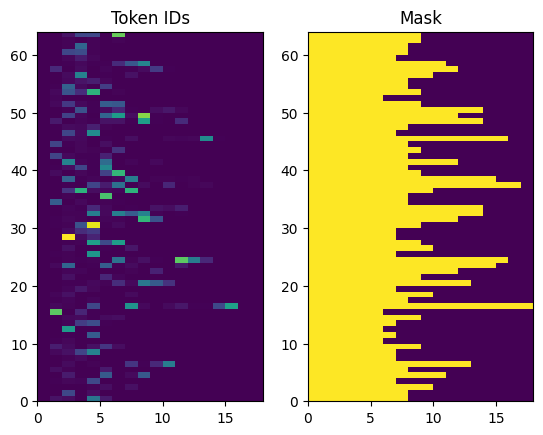

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the text

In [20]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    target_in = target[:, :-1].to_tensor()
    target_out = target[:, 1:].to_tensor()
    return (context, target_in), target_out

In [21]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_targ_in), ex_targ_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_targ_in[0, :10].numpy())
    print(ex_targ_out[0, :10].numpy())

[   2    7   10   66 1265    1  355    4    3    0]

[  2   5  47  84 989 123 410   4   0   0]
[  5  47  84 989 123 410   4   3   0   0]


### The Encoder/Decoder

In [23]:
context_text_processor.vocabulary_size

<bound method TextVectorization.vocabulary_size of <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001C7D12DD540>>

In [24]:
UNITS = 256

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
        self.rnn = tf.keras.layers.Bidirectional(merge_mode='sum',
                                                layer=tf.keras.layers.GRU(units,
                                                                         return_sequences=True,
                                                                         recurrent_initializer='glorot_uniform'))
    def call(self, x):
        x = self.embedding(x)
        x = self.rnn(x)
        return x
    
    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts =tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context
            

#### Try it out

In [26]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f"Context token, shape(batch, s): {ex_context_tok.shape}")
print(f"Result of context, shape(batch, s, units): {ex_context.shape}")

Context token, shape(batch, s): (64, 22)
Result of context, shape(batch, s, units): (64, 22, 256)


### Attention Layer

In [27]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x,
                                           value=context, 
                                           return_attention_scores=True)
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights= attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [28]:
attention_layer = CrossAttention(UNITS)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), UNITS, mask_zero=True)
ex_tar_embed = embed(ex_targ_in)
result = attention_layer(ex_tar_embed, ex_context)

print(f"Context sequence, shape(batch, s, units): {ex_context.shape}")
print(f"Target sequence, shape(batch, t, units): {ex_tar_embed.shape}")
print(f"Attention result, shape(batch, t, units): {result.shape}")
print(f"Attention weights, shape(batch, t, s): {attention_layer.last_attention_weights.shape}")

Context sequence, shape(batch, s, units): (64, 22, 256)
Target sequence, shape(batch, t, units): (64, 16, 256)
Attention result, shape(batch, t, units): (64, 16, 256)
Attention weights, shape(batch, t, s): (64, 16, 22)


In [29]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.9999999 , 0.99999994, 1.0000001 ,
       1.        , 0.9999999 , 1.        , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 ], dtype=float32)

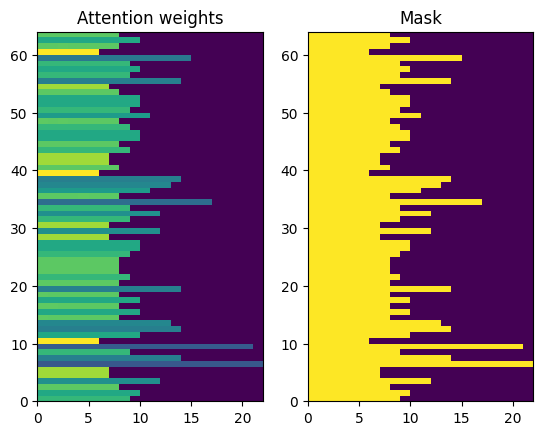

In [30]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [31]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, text_processor, units):
        super().__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]'
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]', invert=True
        )
    
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')
        
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.units, mask_zero=True)
        self.rnn = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        
        self.attention = CrossAttention(self.units)
        
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Training

In [32]:
@Decoder.add_method
def call(self, 
        context, x, state=None, return_state=False):
    x = self.embedding(x)
    x, state = self.rnn(x, initial_state=state)
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    
    logits = self.output_layer(x)
    
    if return_state:
        return logits, state
    else:
        return logits

In [33]:
decoder = Decoder(target_text_processor, UNITS)

In [34]:
logits = decoder(ex_context, ex_targ_in)

print(f"Encoder output shape, (batch, s, units): {ex_context.shape}")
print(f"input target tokens shape:(batch, t): {ex_targ_in.shape}")
print(f"logits shape: (batch,t, target_vocabulary_size): {logits.shape}")

Encoder output shape, (batch, s, units): (64, 22, 256)
input target tokens shape:(batch, t): (64, 16)
logits shape: (batch,t, target_vocabulary_size): (64, 16, 5000)


#### Inference
To use it for inference you'll need a couple more methods:

In [35]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embed = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embed)[0]

In [36]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [37]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    logits, state = self(context, next_token, state=state, return_state=True)
    
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/ temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    done = done | (self.end_token == next_token)
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    
    return next_token, done, state

In [38]:
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []
for n in range(10):
    next_token, done, state = decoder.get_next_token(ex_context, next_token, done, state, temperature=1.0)
    tokens.append(next_token)

In [39]:
np.array(tokens).shape

(10, 64, 1)

In [40]:
tokens = tf.concat(tokens, axis=-1) # batch, t
tokens.shape

TensorShape([64, 10])

In [41]:
# convert the tokens back to a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'sober m lasted witness fact manner dawn border fountain stuck',
       b'deny fever ones pity italy rides sword land dated mouth',
       b'humor fifteen fireman sickness wealth voyage improving youre makeup closest'],
      dtype=object)

### The Model

In [42]:
class Translator(tf.keras.models.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    def __init__(self,units,  context_text_processor, target_text_processor):
        super().__init__()
        # build the model
        endcoder =Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)
        self.encoder =encoder
        self.decoder = decoder
    
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)
        
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits

During training modell will be used like this

In [43]:
model = Translator(UNITS, context_text_processor, target_text_processor)
logits = model((ex_context_tok, ex_targ_in))

print(f"Context tokens, shape: (batch, s, units): {ex_context_tok.shape}")
print(f'Target tokens, shape: (batch, t): {ex_targ_in.shape}')
print(f'logits shape: (batch, target_vocabulary_size): {logits.shape}')

Context tokens, shape: (batch, s, units): (64, 22)
Target tokens, shape: (batch, t): (64, 16)
logits shape: (batch, target_vocabulary_size): (64, 16, 5000)


### Train 


In [44]:
def masked_loss(y_true, y_pred):
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [45]:
def masked_accuracy(y_true, y_pred):
    # calculate the loss for each item in the batch
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [46]:
model.compile(optimizer='adam',
             loss=masked_loss,
             metrics=[masked_accuracy, masked_loss])


In [47]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [48]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 20s 213ms/step - loss: 8.5027 - masked_accuracy: 9.1241e-05 - masked_loss: 8.5027


{'loss': 8.502697944641113,
 'masked_accuracy': 9.124087227974087e-05,
 'masked_loss': 8.502697944641113}

In [49]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch=100,
    validation_data=val_ds,
    validation_steps= 20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/100
100/100 [==============================] - 77s 520ms/step - loss: 4.8884 - masked_accuracy: 0.2861 - masked_loss: 4.8884 - val_loss: 3.9539 - val_masked_accuracy: 0.3818 - val_masked_loss: 3.9539
Epoch 2/100
100/100 [==============================] - 53s 531ms/step - loss: 3.5843 - masked_accuracy: 0.4176 - masked_loss: 3.5843 - val_loss: 3.2981 - val_masked_accuracy: 0.4586 - val_masked_loss: 3.2981
Epoch 3/100
100/100 [==============================] - 53s 526ms/step - loss: 3.0988 - masked_accuracy: 0.4796 - masked_loss: 3.0988 - val_loss: 2.9113 - val_masked_accuracy: 0.5103 - val_masked_loss: 2.9113
Epoch 4/100
100/100 [==============================] - 54s 538ms/step - loss: 2.7804 - masked_accuracy: 0.5217 - masked_loss: 2.7804 - val_loss: 2.5859 - val_masked_accuracy: 0.5497 - val_masked_loss: 2.5859
Epoch 5/100
100/100 [==============================] - 51s 510ms/step - loss: 2.5267 - masked_accuracy: 0.5593 - masked_loss: 2.5267 - val_loss: 2.3986 - val_masked_acc

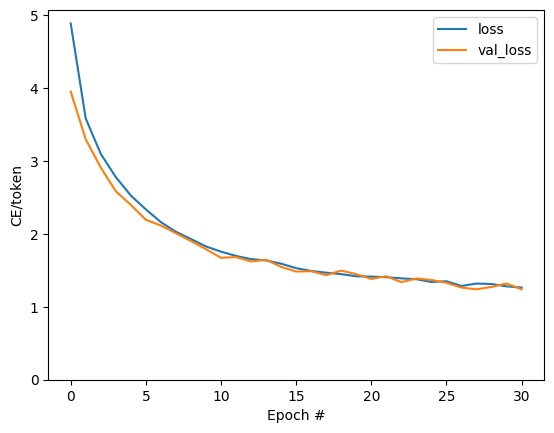

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

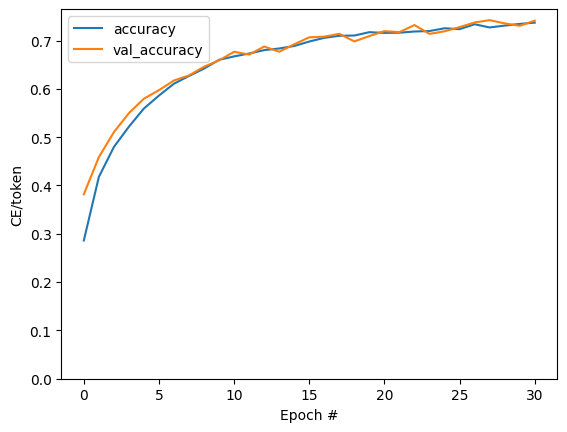

In [51]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [76]:
@Translator.add_method
def translate(self, texts, *, max_length=50, temperature=0.0):
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]
    
    # setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)
    
    for _ in range(max_length):
        # generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done, state, temperature
        )
        # collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
        
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
    # Stack the lists of tokens and attention weights
    tokens = tf.concat(tokens, axis=-1)
    self.last_attention_weights = tf.concat(attention_weights, axis=-1)
    
    result = self.decoder.tokens_to_text(tokens)
    
    return result

In [80]:
result = model.translate(['Seien Sie nett!']) # Be nice

result[0].numpy().decode()

'be nice . '